In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

In [2]:
# Максимальное количество отображаемых столбцов
pd.set_option('display.max_columns', 13)
# Максимальное количество отображаемых строк
pd.set_option('display.max_rows', 10)
# Максимальная ширина столбца
pd.set_option('display.max_colwidth', 45)
# Максимальная ширина отображения
pd.set_option('display.width', 80)

## Предобработка данных из датасета

In [3]:
df = pd.read_csv('music_prepared.csv')
df['explicit'] = df['explicit'].astype(float)
df = (df - df.mean()) / df.std()
df_train, df_test = train_test_split(df, train_size=0.8, random_state=1)

df_train

,popularity,duration_ms,explicit,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1233,-1.348206,-0.362849,-0.278098,0.385466,-1.004434,-1.512838,...,7.789777,-0.374744,-0.774437,-0.316892,0.216636,-0.707036
1056,1.228249,-0.679809,-0.278098,0.906171,0.672831,0.463621,...,-0.217156,2.173298,-1.167189,-0.807731,0.216636,-0.707036
1686,0.910604,-0.530295,-0.278098,-0.169953,-0.026029,-0.948136,...,-0.227910,-0.499474,-0.589093,0.893621,0.216636,-0.707036
187,-1.348206,-0.198054,-0.278098,0.996427,0.238540,1.310675,...,-0.227267,-0.368805,-0.399337,-0.319413,0.216636,-1.414072
3840,-0.112919,-0.944179,-0.278098,-0.412948,1.276846,-1.230487,...,-0.227910,3.509684,-0.456705,-0.985063,0.216636,0.707036
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0.945898,-0.997070,-0.278098,-0.780913,-1.523587,0.463621,...,-0.227910,-0.588566,0.041958,1.211810,0.216636,0.000000
2763,0.945898,0.468509,-0.278098,-0.426834,0.577986,1.310675,...,-0.227910,0.605272,-0.880348,-1.399219,0.216636,0.000000
905,0.134138,0.345097,-0.278098,-1.134992,-0.495264,-0.665784,...,-0.197046,-0.576687,-1.692329,0.566068,0.216636,-1.414072
3980,-0.112919,0.304737,-0.278098,-0.773970,0.203597,1.593026,...,-0.227910,0.260781,1.233452,0.429762,0.216636,0.707036


In [4]:
y_train = torch.tensor(df_train['popularity'].values).float()
y_test = torch.tensor(df_test['popularity'].values).float()
X_train = torch.tensor(df_train.drop(columns='popularity', inplace=False).values).float()
X_test = torch.tensor(df_test.drop(columns='popularity', inplace=False).values).float()

## Глубокое обучение
### Задание 1
Создание начальной нейросети:

In [5]:
def create_model(hid_size=50, num_features=15, n_out=1):
    torch.manual_seed(1)
    model = nn.Sequential(
        nn.Linear(num_features, hid_size),
        nn.ReLU(),
        nn.Linear(hid_size, hid_size // 2),
        nn.ReLU(),
        nn.Linear(hid_size // 2, n_out), 
    )
    return model

In [6]:
model = create_model()

In [7]:
model[0].weight[0][0]

tensor(0.1330, grad_fn=<SelectBackward0>)

### Задание 2
Обучение созданной нейросети:

In [8]:
def train_model(model, opt, X_train, y_train, X_test, y_test, n_epoch=100):
    loss_fn = F.mse_loss
    loss_train, loss_test = [], []


    for epoch_num in range(n_epoch):
        opt.zero_grad()  # обнуление градиентов
        y_predicted = model(X_train.float()).view(-1)  # получение предсказаний
        loss = loss_fn(y_predicted, y_train)  # подсчет функции потерь

        loss.backward()  # обратный проход
        opt.step()  # шаг оптимизации
        loss_train.append(np.sqrt(loss.item()))

        y_pred = model(X_test).view(-1)  # получение предсказаний на тесте
        mse = loss_fn(y_pred, y_test)  # подсчет функции потерь на тесте
        loss_test.append(np.sqrt(mse.item()))
        
    return model, loss_train, loss_test 

In [9]:
lr = 0.01
RMSE_model = create_model()
RMSE_SGD = train_model(RMSE_model, torch.optim.SGD(RMSE_model.parameters(), lr=lr), X_train, y_train, X_test, y_test, 100)[-1][-1]
Adagrad_model = create_model()
RMSE_Adagrad = train_model(Adagrad_model, torch.optim.Adagrad(Adagrad_model.parameters(), lr=lr), X_train, y_train, X_test, y_test, 100)[-1][-1]
Adam_model = create_model()
RMSE_Adam = train_model(Adam_model, torch.optim.Adam(Adam_model.parameters(), lr=lr), X_train, y_train, X_test, y_test, 100)[-1][-1]
print(f'SGD: {RMSE_SGD}, Adagrad: {RMSE_Adagrad}, Adam: {RMSE_Adam}')

SGD: 1.011600620045289, Adagrad: 0.9305364755474225, Adam: 0.9241168677829904


### Задания 3 и 4
Переход к задаче классификации:

In [10]:
df = pd.read_csv('music_prepared.csv')
df['explicit'] = df['explicit'].astype(float)
df_train, df_test = train_test_split(df, train_size=0.8, random_state=1)
y_train = torch.tensor(df_train['popularity'].values).float()
y_test = torch.tensor(df_test['popularity'].values).float()

y_train_bin = y_train.clone().detach()
for i in range(len(y_train_bin)): y_train_bin[i] = 1. if (y_train[i] > 50) else 0.
y_test_bin = y_test.clone().detach()
for i in range(len(y_test_bin)): y_test_bin[i] = 1. if (y_test[i] > 50) else 0.

In [26]:
def create_model(hid_size=50, num_features=15, n_out=1):
    torch.manual_seed(1)
    model = nn.Sequential(
        nn.Linear(num_features, hid_size),
        nn.ReLU(),
        nn.Linear(hid_size, hid_size),
        nn.ReLU(),
        nn.Linear(hid_size, n_out), 
        nn.Sigmoid()
    )
    return model

In [27]:
model = create_model()
model(X_test[0])

tensor([0.4741], grad_fn=<SigmoidBackward0>)

In [28]:
def train_model(model, opt, X_train, y_train, X_test, y_test, n_epoch=100, log_period=10):
    loss_fn = F.binary_cross_entropy
    loss_train, loss_test = [], []
    acc_train, acc_test = [], []

    for epoch_num in range(n_epoch):
        opt.zero_grad()  # обнуление градиентов
        y_predicted = model(X_train).view(-1)  # получение предсказаний
        loss = loss_fn(y_predicted, y_train) # подсчет функции потерь

        loss.backward()  # обратный проход
        opt.step()  # шаг оптимизации

        if epoch_num % log_period == 0:
            loss_train.append(loss.item())
            
            acc = accuracy_score(torch.round(y_predicted).detach().numpy(), y_train.detach().numpy())  # подсчет метрики на обучении
            acc_train.append(acc)

            y_pred = model(X_test).view(-1)  # получение предсказаний на тесте
            bce = loss_fn(y_pred, y_test)  # подсчет функции потерь на тесте
            loss_test.append(bce.item())

            acc = accuracy_score(torch.round(y_pred).detach().numpy(), y_test.detach().numpy())  # подсчет метрики на тесте
            acc_test.append(acc)

    return model, loss_train, loss_test, acc_train, acc_test 

In [29]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
model, loss_train, loss_test, acc_train, acc_test = train_model(model, opt, X_train, y_train_bin, X_test, y_test_bin, n_epoch=200)
epochs = [epoch_num for epoch_num in range(200) if epoch_num % 10 == 0]

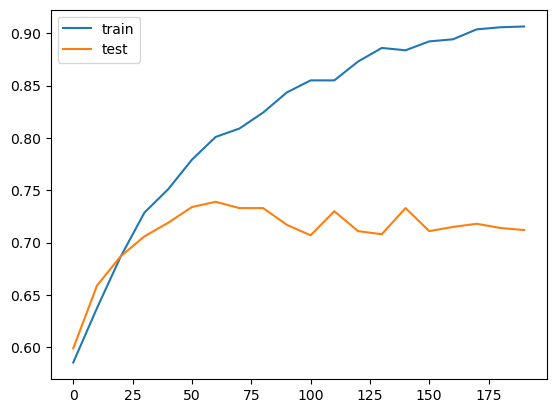

In [30]:
plt.plot(epochs, acc_train, epochs, acc_test)
plt.legend(('train', 'test'))

### Задание 5
Добавление дополнительных слоёв в нейросеть:

In [34]:
def create_model(hid_size=50, num_features=15, n_out=1):
    torch.manual_seed(1)
    model = nn.Sequential(
        nn.Linear(num_features, hid_size),
        nn.BatchNorm1d(num_features=hid_size),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(hid_size, hid_size),
        nn.BatchNorm1d(num_features=hid_size),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(hid_size, n_out), 
        nn.Sigmoid()
    )
    return model

In [35]:
model = create_model()
opt = torch.optim.Adam(model.parameters(), lr=0.01)
model, loss_train, loss_test, acc_train, acc_test = train_model(model, opt, X_train, y_train_bin, X_test, y_test_bin, n_epoch=200)
epochs = [epoch_num for epoch_num in range(200) if epoch_num % 10 == 0]

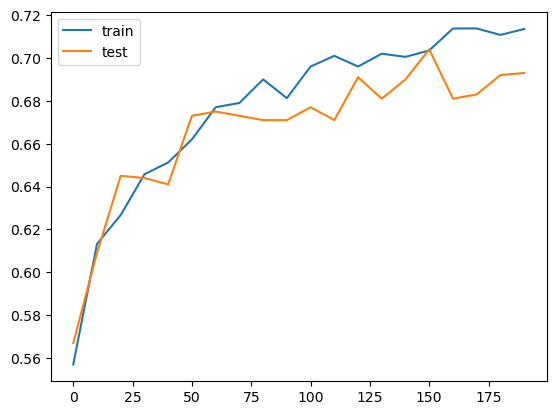

In [36]:
plt.plot(epochs, acc_train, epochs, acc_test)
plt.legend(('train', 'test'))

In [37]:
acc_train[-1] - acc_test[-1]

0.020500000000000074